# Data preparation for sequence models

Here we must transform previously recovered onset data into a format that can be fed into a RNN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
%run ../../Utilities/Utilities.ipynb

Using TensorFlow backend.


In [3]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_corrected.pkl")

## Loading the waveform into the DataFrame

In [4]:
samples_path = "../../Samples/Guitar/Riffs/"

In [5]:
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [6]:
wave = waveform(samples_path + "Guitar_noamp_riff1.mp3")

In [7]:
data["x"] = data["File"].progress_apply(lambda x: waveform(samples_path + x).y)

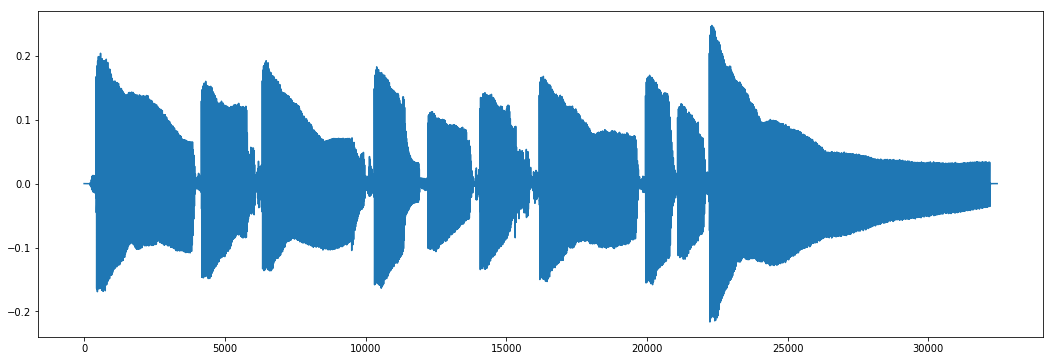

In [8]:
plt.figure(figsize=(18,6))
plt.plot(data["x"].sample().values[0])

## Creating the onset signal (target)

In [9]:
def create_onset_wave(x):
    onsets = x.loc["Onsets"]
    wave = x.loc["x"]
    y = np.zeros(int(wave.shape[0]/10))
    for onset in onsets:
        y[int(onset/10):int(onset/10)+20] = 1
    return y

In [10]:
data["y"] = data.apply(create_onset_wave, axis=1)

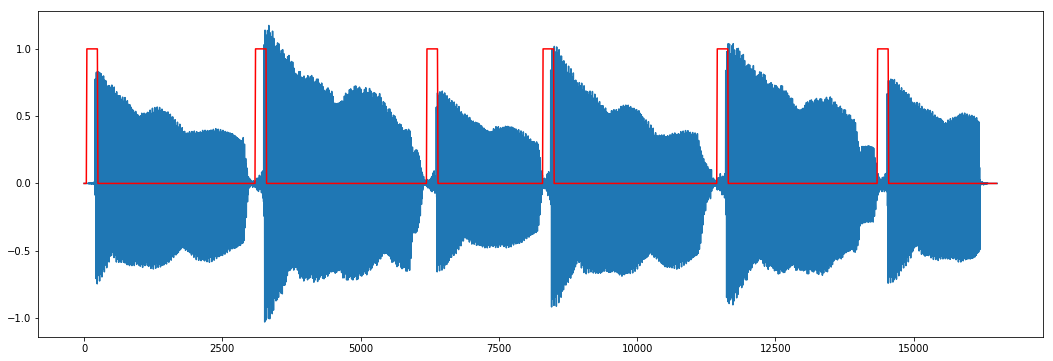

In [16]:
row = data.sample()
plt.figure(figsize=(18,6))
plt.plot(3 * row["x"].values[0])
plt.plot(np.arange(0, row["y"].values[0].shape[0]*10, 10), row["y"].values[0], "r")

In [17]:
data.to_pickle("../../Data/Guitar/File_onset_data_final.pkl")

## Padding both input and target waves to a uniform length

In [18]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [19]:
(data["x"].apply(lambda x: x.shape[0])).max()

48385

In [20]:
max_length = 50000

In [21]:
def pad(seq, max_length):
    if seq.shape[0] < max_length:
        seq = np.append(seq, [0] * (max_length - seq.shape[0]))
    else:
        seq = seq[:max_length]
    return seq

In [22]:
data["x"] = data["x"].apply(lambda x: pad(x, max_length))
data["y"] = data["y"].apply(lambda x: pad(x, int(max_length/10)))

In [23]:
(data["x"].apply(lambda x: x.shape[0])).mean()

50000.0

In [24]:
(data["y"].apply(lambda x: x.shape[0])).mean()

5000.0

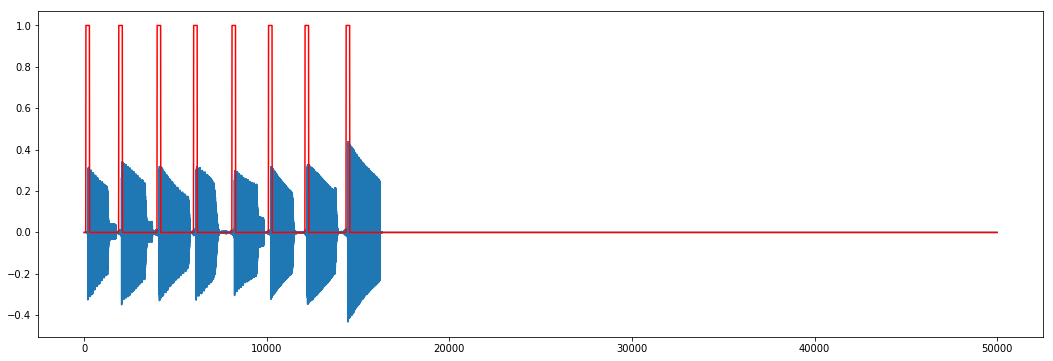

In [27]:
row = data.sample()
plt.figure(figsize=(18,6))
plt.plot(3 * row["x"].values[0])
plt.plot(np.arange(0, row["y"].values[0].shape[0]*10, 10), row["y"].values[0], "r")

In [28]:
data.to_pickle("../../Data/Guitar/File_onset_data_final.pkl")

## Spectral data

In [29]:
def to_spectral(x, samples):
    xf = np.zeros((x.shape[0] // samples, samples))
    for i in range(0, x.shape[0], samples):
        w = abs(np.fft.fft(x[i:i+samples], n=samples*2))
        freqs = np.fft.fftfreq(len(w))
        xf[i//50, :] = w[freqs >= 0]
    return xf

In [30]:
data["xf"] = data["x"].progress_apply(lambda x: to_spectral(x, 50))

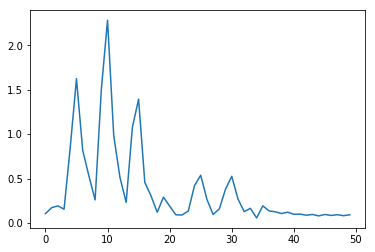

In [31]:
plt.plot(data["xf"].sample().values[0][100])

In [32]:
data.to_pickle("../../Data/Guitar/File_onset_data_final.pkl")

## Noises

### Temporal

In [33]:
import IPython.display as ipd

In [34]:
noises = []
noises_path = "../../Samples/Guitar/Noises/"
for noise_file in os.listdir(noises_path):
    noise = waveform(noises_path + noise_file)
    noises.append(noise.y.reshape(noise.y.shape[0], 1))

In [35]:
ipd.Audio(noises[0][:,0], rate=8000)

In [36]:
np.save("../../Data/Guitar/noises_temporal.npy", np.array(noises), allow_pickle=True)

In [37]:
noises = np.load("../../Data/Guitar/noises_temporal.npy", allow_pickle=True)

In [38]:
ipd.Audio(noises[0][:,0], rate=8000)

### Spectral

In [39]:
def to_spectral(x, samples):
    xf = np.zeros((x.shape[0] // samples, samples))
    for i in range(0, x.shape[0]-samples, samples):
        w = abs(np.fft.fft(x[i:i+samples], n=samples*2))
        freqs = np.fft.fftfreq(len(w))
        xf[i//50, :] = w[freqs >= 0]
    return xf

In [40]:
noises_f = []
for noise in noises:
    noises_f.append(to_spectral(noise[:,0], 50))

In [41]:
np.save("../../Data/Guitar/noises_spectral.npy", np.array(noises_f), allow_pickle=True)

In [42]:
noises_f[0].shape

(88, 50)